# 0.0. IMPORTS

In [1]:
import warnings
import pandas as pd
import numpy  as np

import seaborn as sns
import xgboost as xgb

from matplotlib            import pyplot as plt
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings( 'ignore' )

## 0.1. Helper Functions

In [2]:
def calc_smooth_mean( df, by, on , m ):
    # compute the global mean
    mean = df[on].mean()
    
    # compute the number of values and the mean of each group
    agg = df.groupby( by )[on].agg( ['count', 'mean'] )
    counts = agg['count']
    means = agg['mean']
    
    # compute the "smoothed" means
    smooth = ( counts * means + m * mean ) / ( counts + m )
    
    # replace each value by the according smoothed mean
    return df[by].map( smooth )



def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )



def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] ) 
    
    
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Dataset

In [4]:
df_raw = pd.read_csv( '../data/data_labs.csv' )

# 1.0. DESCRICAO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

In [6]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 179149
Number of Cols: 14


## 1.2. Data Types

In [7]:
df1.dtypes

order_id             object
code                 object
quantity              int64
price               float64
pis_cofins          float64
icms                float64
tax_substitution    float64
category             object
liquid_cost         float64
order_status         object
capture_date         object
process_date         object
process_status       object
source_channel       object
dtype: object

## 1.3. Check NA

In [8]:
df1.isna().sum()

order_id            0
code                0
quantity            0
price               0
pis_cofins          0
icms                0
tax_substitution    0
category            0
liquid_cost         0
order_status        0
capture_date        0
process_date        0
process_status      0
source_channel      0
dtype: int64

## 1.4. Change Data Types

In [9]:
# Date format
df1['capture_date'] = pd.to_datetime( df1['capture_date'] )

df1.loc[df1['process_date'] == '0000-00-00', 'process_date'] = '1900-01-01'
df1['process_date'] = pd.to_datetime( df1['process_date'] )

## 1.5. Descriptive Statistics

### 1.5.1. Numerical

In [10]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes = df1.select_dtypes( include=['datetime64[ns]'] )

In [11]:
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,1.0000,100.0000,99.0000,1.055278,1.0000,0.597940,60.085256,6821.090621
1,price,1.0300,19993.0000,19991.9700,234.638585,194.4000,186.638398,27.109077,2125.723778
2,pis_cofins,0.0000,1849.3525,1849.3525,19.525329,17.5195,17.402772,22.766807,1777.300240
3,icms,0.0000,3598.7400,3598.7400,25.095547,21.4920,32.333136,14.203649,1096.176530
4,tax_substitution,0.0000,280.8342,280.8342,17.872443,0.0000,28.125583,2.211765,8.212045
5,liquid_cost,4.1141,896.6814,892.5673,136.034906,117.0820,83.603010,2.066601,8.568905


### 1.5.2. Categorical

In [12]:
cat_attributes = cat_attributes.drop( ['order_id'], axis=1 )

In [13]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

code              131
category           11
order_status       17
process_status      2
source_channel     16
dtype: int64

### 1.5.3. Temporal

# 2.0. FEATURE ENGINEERING

In [14]:
df2 = df1.copy()

## 2.1. Feature Engineering

In [15]:
# year
df2['capture_date_year'] = df2['capture_date'].dt.year
df2['process_date_year'] = df2['process_date'].dt.year

# month
df2['capture_date_month'] = df2['capture_date'].dt.month
df2['process_date_month'] = df2['process_date'].dt.month

# day
df2['capture_date_day'] = df2['capture_date'].dt.day
df2['process_date_day'] = df2['process_date'].dt.day

# week of year
df2['capture_date_week_of_year'] = df2['capture_date'].dt.weekofyear
df2['process_date_week_of_year'] = df2['process_date'].dt.weekofyear

# year week
df2['capture_year_week'] = df2['capture_date'].dt.strftime( '%Y-%W' )
df2['process_year_week'] = df2['process_date'].dt.strftime( '%Y-%W' )

# unit price
df2['unit_price'] = df2['price'] / df2['quantity']

# Category
old_category = list( df2['category'].drop_duplicates() )
new_category = [ 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11' ]
category_de_para = dict( zip( old_category, new_category ) ) 
df2['category'] = df2['category'].map( category_de_para )

# Produts ( code )
old_products = list( df2['code'].drop_duplicates() )
new_products = ['P' + str( i ) for i in np.arange( 100, 232 )]
code_de_para = dict( zip( old_products, new_products ) )
df2['code'] = df2['code'].map( code_de_para )

# Source Channel
old_channel = list( df2['source_channel'].drop_duplicates() )
new_channel = ['channel' + str( i ) for i in np.arange( 1, 17 ) ]
channel_de_para = dict( zip( old_channel, new_channel ) )
df2['source_channel'] = df2['source_channel'].map( channel_de_para )

# Order Id
old_order = list( df2['order_id'].drop_duplicates() )
new_order = [i for i in np.arange( 1, 175576 )]
order_de_para = dict( zip( old_order, new_order ) )
df2['order_id'] = df2['order_id'].map( order_de_para )

# Time Lagging - All Quantity
df2['lag_07'] = df2['quantity'].shift( 7 )
df2['lag_15'] = df2['quantity'].shift( 15 )
df2['lag_30'] = df2['quantity'].shift( 30 )

# Time Lagging - Year and Month
qtde_month = df2[['capture_date_year', 'capture_date_month', 'quantity']].groupby( ['capture_date_year', 'capture_date_month'] ).sum().reset_index().rename( columns={'quantity': 'qtde_month'})
qtde_month['lag_01_month'] = qtde_month['qtde_month'].shift( 1 )
qtde_month['lag_02_month'] = qtde_month['qtde_month'].shift( 2 )
qtde_month['lag_03_month'] = qtde_month['qtde_month'].shift( 3 )
df2 = pd.merge( df2, qtde_month, how='left', on=['capture_date_year', 'capture_date_month'] )

# Time Lagging - Year and Month Category
qtde_month_category = df2[['capture_date_year', 'capture_date_month', 'category', 'quantity']].groupby( ['capture_date_year', 'capture_date_month', 'category'] ).sum().reset_index().rename( columns={'quantity': 'qtde_month_category'})
qtde_month_category['lag_01_month_category'] = qtde_month_category['qtde_month_category'].shift( 1 )
qtde_month_category['lag_02_month_category'] = qtde_month_category['qtde_month_category'].shift( 2 )
qtde_month_category['lag_04_month_category'] = qtde_month_category['qtde_month_category'].shift( 3 )
df2 = pd.merge( df2, qtde_month_category, how='left', on=['capture_date_year', 'capture_date_month', 'category'] )


# Drop NA
df2 = df2.dropna()

# 3.0. FILTRAGEM DE VARIÁVEIS

In [16]:
df3 = df2.copy()

## 3.1. Seleção das Linhas

## 3.2. Seleção das Colunas

In [17]:
drop_cols = [
    'order_id',
    'price', 
    'pis_cofins', 'icms', 'tax_substitution', 'liquid_cost', 
    'order_status', 'process_status',
    'process_date', 'process_date_year', 'process_date_month', 'process_date_day', 'process_date_week_of_year', 'process_year_week',
    'source_channel']

df3 = df3.drop( drop_cols, axis=1 )

## 3.3. Granularidade

In [18]:
# Sales by Day
cols_agg = list( df3.drop( 'quantity', axis=1 ).columns )
df3 = df3.groupby( cols_agg ).sum().reset_index()

# 4.0. ANÁLISE EXPLORATÓRIA DE DADOS

In [19]:
df4 = df3.copy()

## 4.1. Analise Univariada

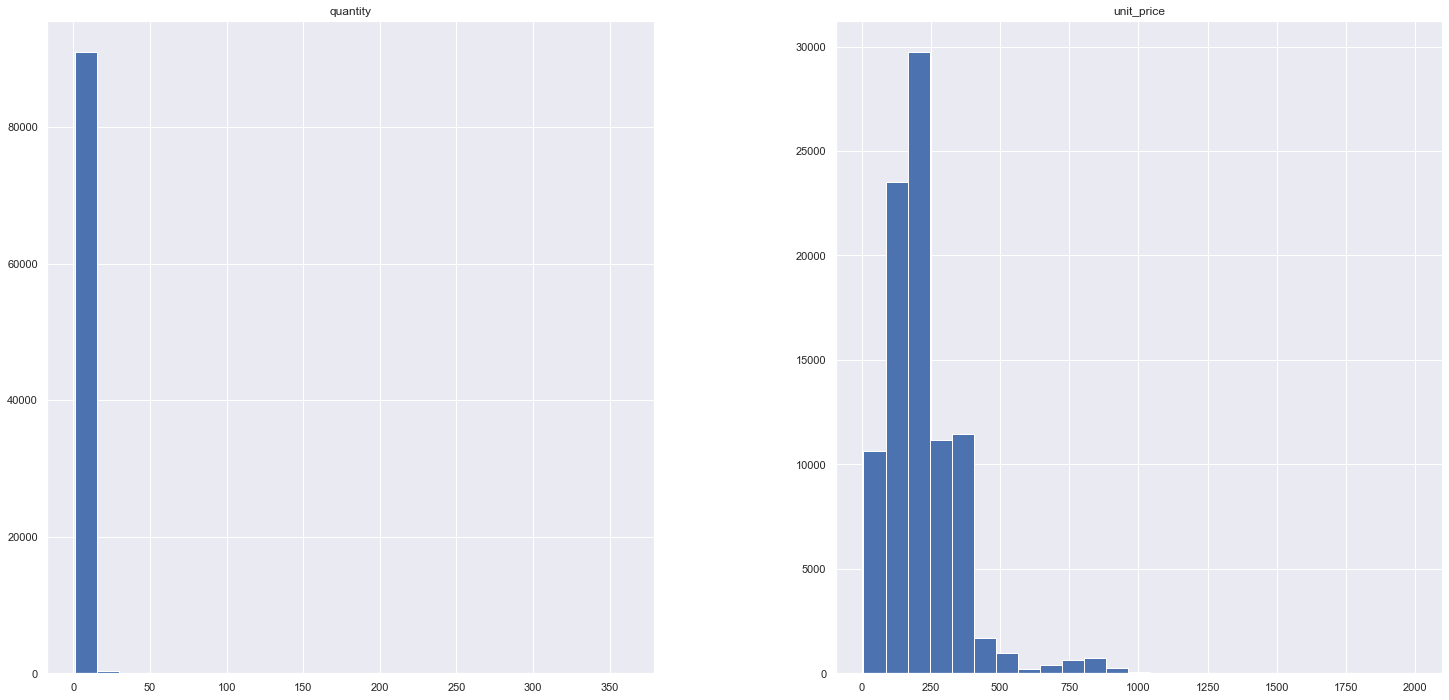

In [20]:
df4[['quantity', 'unit_price']].hist( bins=25 );

## 4.2. Analise Bivariada

In [21]:
aux = df4[['code', 'quantity', 'capture_date']].groupby( ['code', 'capture_date'] ).sum().reset_index()
aux = aux[aux['capture_date'] != '1900-01-01']

In [22]:
aux.head()

,code,capture_date,quantity
0,P100,2016-12-21,2
1,P100,2016-12-29,1
2,P100,2016-12-31,1
3,P100,2017-01-08,1
4,P100,2017-01-10,1


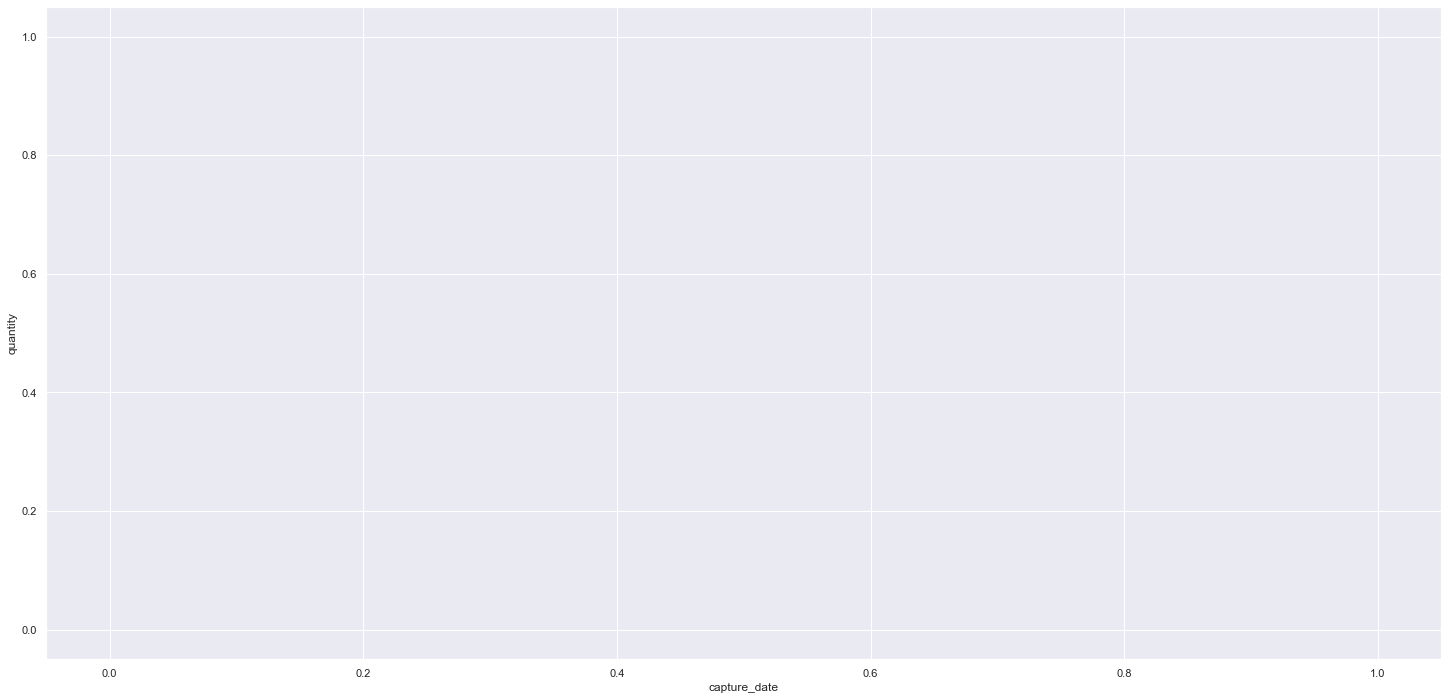

In [23]:
 sns.lineplot( x='capture_date', y='quantity', data=aux[aux['code'] == 'P1'] ) 

## 4.3. Analise Multivariada

# 5.0. DATA PREPARATION

In [24]:
df5 = df4.copy()

In [25]:
df5.head()

,code,category,capture_date,capture_date_year,capture_date_month,capture_date_day,capture_date_week_of_year,capture_year_week,unit_price,lag_07,lag_15,lag_30,qtde_month,lag_01_month,lag_02_month,lag_03_month,qtde_month_category,lag_01_month_category,lag_02_month_category,lag_04_month_category,quantity
0,P100,C01,2016-12-21,2016,12,21,51,2016-51,893.23,1.0,1.0,1.0,15954,22400.0,12714.0,13787.0,9,260.0,17.0,38.0,1
1,P100,C01,2016-12-21,2016,12,21,51,2016-51,948.96,1.0,1.0,1.0,15954,22400.0,12714.0,13787.0,9,260.0,17.0,38.0,1
2,P100,C01,2016-12-29,2016,12,29,52,2016-52,885.10,1.0,1.0,1.0,15954,22400.0,12714.0,13787.0,9,260.0,17.0,38.0,1
3,P100,C01,2016-12-31,2016,12,31,52,2016-52,885.10,1.0,1.0,1.0,15954,22400.0,12714.0,13787.0,9,260.0,17.0,38.0,1
4,P100,C01,2017-01-08,2017,1,8,1,2017-01,1002.00,1.0,1.0,1.0,23343,15954.0,22400.0,12714.0,11,2.0,73.0,20.0,1


## 5.3. Encoding

In [26]:
# Target Encoding
df5['enc_category'] = calc_smooth_mean( df5, by='category', on='quantity', m=300 )

# Dummy Variables
df5 = pd.get_dummies( df5, columns=['category'] )

## 5.4. Transformação

In [27]:
# Unit Price
df5['enc_unit_price'] = np.log1p( df5['unit_price'] )

# 6.0. FEATURE SELECTION

In [28]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [29]:
# training dataset
X_train = df6[df6['capture_date'] < '2017-03-01']
y_train = X_train['quantity']

# test dataset
X_test = df6[df6['capture_date'] >= '2017-03-01']
y_test = X_test['quantity']

print( 'Training Min Date: {}'.format( X_train['capture_date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['capture_date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['capture_date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['capture_date'].max() ) )

Training Min Date: 2016-09-01 00:00:00
Training Max Date: 2017-02-28 00:00:00

Test Min Date: 2017-03-01 00:00:00
Test Max Date: 2017-06-01 00:00:00


## 6.3. Manual Feature Selection

In [47]:
cols_selected_boruta = [
    'capture_date_year',
    'capture_date_month',
    'capture_date_day',
    'capture_date_week_of_year',
    'enc_unit_price',
    'lag_07',
    'lag_15',
    'lag_30',
    'qtde_month',
    'lag_01_month',
    'lag_02_month',
    'lag_03_month',
    'qtde_month_category',
    'lag_01_month_category',
    'lag_02_month_category',
    'lag_04_month_category',
    'enc_category',
    #'category_C01',
    #'category_C02',
    #'category_C03',
    #'category_C04',
    #'category_C05',
    #'category_C06',
    #'category_C07',
    #'category_C08',
    #'category_C09',
    #'category_C10',
    #'category_C11',
]


# columns to add
feat_to_add = ['code', 'capture_date', 'quantity']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. MACHINE LEARNING MODELLING

In [48]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

## 7.1. Average Model

In [49]:
aux1 = X_test.copy()
aux1['quantity'] = y_test.copy()

# prediction
aux2 = aux1[['code', 'quantity']].groupby( 'code' ).mean().reset_index().rename( columns={'quantity': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='code' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', y_test, yhat_baseline ) 
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,0.983951,0.657738,2.603054


## 7.2. Linear Regression Model

In [50]:
x_train.head()

,capture_date_year,capture_date_month,capture_date_day,capture_date_week_of_year,enc_unit_price,lag_07,lag_15,lag_30,qtde_month,lag_01_month,lag_02_month,lag_03_month,qtde_month_category,lag_01_month_category,lag_02_month_category,lag_04_month_category,enc_category
0,2016,12,21,51,6.795963,1.0,1.0,1.0,15954,22400.0,12714.0,13787.0,9,260.0,17.0,38.0,1.65126
1,2016,12,21,51,6.856420,1.0,1.0,1.0,15954,22400.0,12714.0,13787.0,9,260.0,17.0,38.0,1.65126
2,2016,12,29,52,6.786830,1.0,1.0,1.0,15954,22400.0,12714.0,13787.0,9,260.0,17.0,38.0,1.65126
3,2016,12,31,52,6.786830,1.0,1.0,1.0,15954,22400.0,12714.0,13787.0,9,260.0,17.0,38.0,1.65126
4,2017,1,8,1,6.910751,1.0,1.0,1.0,23343,15954.0,22400.0,12714.0,11,2.0,73.0,20.0,1.65126


In [51]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', y_test, yhat_lr )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1.833222,1.43053,3.025075


## 7.3. Linear Regression Model - Lasso

In [52]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', y_test, yhat_lrr )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1.55695,1.16417,2.816662


## 7.4. Random Forest Regressor

In [53]:
# model
rf = RandomForestRegressor( n_estimators=500, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', y_test, yhat_rf )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,0.886197,0.444024,2.619813


## 7.5. XGBoost Regressor

In [54]:
# dummy variable = MAE=1.13, MAPE=0.56, RMSE=3.57

In [55]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=500, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', y_test, yhat_xgb )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1.023681,0.557705,3.10554


## 7.6. Gradient Boosting Regressor ( GBoost )

In [56]:
# modelling
gb = GradientBoostingRegressor( n_estimators=1500, max_features='auto', random_state=42, verbose=0 ).fit( x_train, y_train )

# predictions
yhat_gb = gb.predict( x_test )

# performance
gb_result = ml_error( 'Gradient Boosting Regressor', y_test, yhat_xgb )
gb_result

,Model Name,MAE,MAPE,RMSE
0,Gradient Boosting Regressor,1.023681,0.557705,3.10554


## 7.6. Compare Model Performance

### 7.6.1. Single Performance

In [57]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result, gb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Average Model,0.983951,0.657738,2.603054
0,Random Forest Regressor,0.886197,0.444024,2.619813
0,Linear Regression - Lasso,1.556950,1.164170,2.816662
0,Linear Regression,1.833222,1.430530,3.025075
0,XGBoost Regressor,1.023681,0.557705,3.105540
0,Gradient Boosting Regressor,1.023681,0.557705,3.105540


# 8.0 HYPERPARAMETER FINE TUNING

## 8.1. Random Search

## 8.2. Final Model

# 9.0. TRADUCAO E INTERPRETACAO DO ERRO 

In [58]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['predictions'] = np.round( yhat_xgb, 0 )

In [59]:
df9.head()

,capture_date_year,capture_date_month,capture_date_day,capture_date_week_of_year,enc_unit_price,lag_07,lag_15,lag_30,qtde_month,lag_01_month,lag_02_month,lag_03_month,qtde_month_category,lag_01_month_category,lag_02_month_category,lag_04_month_category,enc_category,code,capture_date,quantity,predictions
13,2017,3,21,12,6.878326,1.0,1.0,1.0,18186,12600.0,23343.0,15954.0,4,2.0,144.0,26.0,1.65126,P100,2017-03-21,1,1.0
14,2017,3,21,12,6.887481,1.0,1.0,1.0,18186,12600.0,23343.0,15954.0,4,2.0,144.0,26.0,1.65126,P100,2017-03-21,1,2.0
15,2017,3,22,12,6.889408,1.0,1.0,1.0,18186,12600.0,23343.0,15954.0,4,2.0,144.0,26.0,1.65126,P100,2017-03-22,1,1.0
16,2017,4,25,17,6.751218,1.0,1.0,1.0,15531,18186.0,12600.0,23343.0,6,2.0,77.0,1.0,1.65126,P100,2017-04-25,1,1.0
17,2017,4,25,17,6.856462,1.0,1.0,1.0,15531,18186.0,12600.0,23343.0,6,2.0,77.0,1.0,1.65126,P100,2017-04-25,1,1.0


In [60]:
df9['error'] = df9['quantity'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['quantity']

## 9.1. Business Performance

In [61]:
aux = df9[['code', 'capture_date_year', 'capture_date_month', 'quantity', 'predictions', 'error']].groupby( ['code', 'capture_date_year', 'capture_date_month'] ).sum().reset_index()
aux.sort_values( 'code' )

,code,capture_date_year,capture_date_month,quantity,predictions,error
0,P100,2017,3,3,4.0,-1.0
1,P100,2017,4,5,6.0,-1.0
2,P100,2017,5,6,15.0,-9.0
3,P101,2017,3,11,19.0,-8.0
4,P101,2017,4,2,2.0,0.0
5,P101,2017,5,6,5.0,1.0
6,P101,2017,6,2,2.0,0.0
7,P102,2017,3,74,104.0,-30.0
8,P102,2017,4,48,55.0,-7.0
9,P102,2017,5,36,48.0,-12.0


## 9.2. Machine Learning Performance

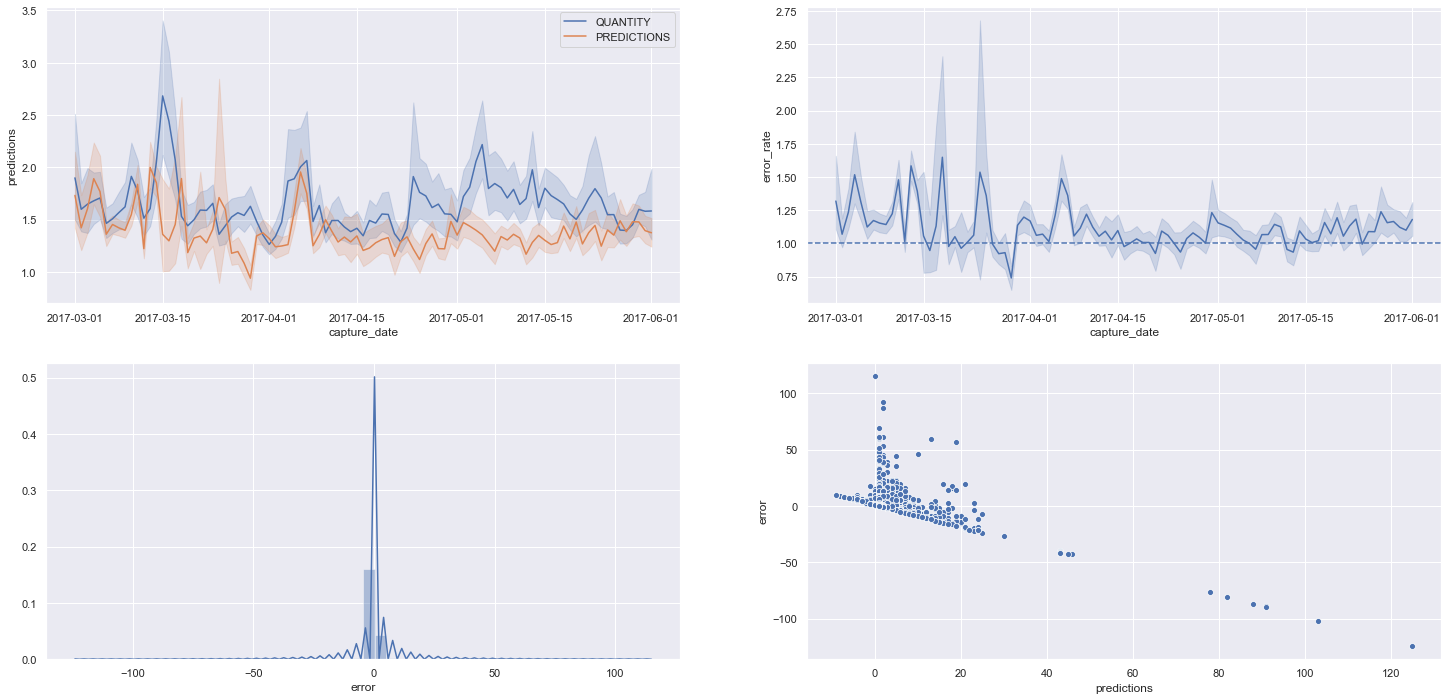

In [62]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='capture_date', y='quantity', data=df9, label='QUANTITY' )
sns.lineplot( x='capture_date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='capture_date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )